In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/MyDrive/ml-final/ML-Final')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import mlflow
import mlflow.sklearn
import dagshub
import joblib
import pickle
import os
from statsmodels.tsa.stattools import adfuller, kpss

warnings.filterwarnings('ignore')

In [4]:
dagshub.init(repo_owner='egval20', repo_name='ML-Final', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=0a4378a0-caac-467f-be25-5f5a5dd20eaf&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=76acb10b74899a0c0d2473aae89b610145a029e947abe88d7452a1a734ac38c4




Accessing as egval20

Initialized MLflow to track repo "egval20/ML-Final"

Repository egval20/ML-Final initialized!

## Data Prep

In [5]:
import joblib
import sys
sys.path.append('.')
from data_preprocessing_pipeline import *

In [ ]:
def get_model_ready_data(pipeline_path='preprocessing_pipeline.pkl'):
    pipeline = joblib.load(pipeline_path)
    def preprocess_for_model(raw_data):
        return pipeline.transform(raw_data)
    return preprocess_for_model, pipeline

preprocess_fn, loaded_pipeline = get_model_ready_data()

train_raw = pd.read_csv('data/train.csv')
test_raw = pd.read_csv('data/test.csv')
stores = pd.read_csv('data/stores.csv')
features = pd.read_csv('data/features.csv')
print(f"Train shape: {train_raw.shape}")
print(f"Test shape: {test_raw.shape}")
print(f"Date range - Train: {train_raw['Date'].min()} to {train_raw['Date'].max()}")
print(f"Date range - Test: {test_raw['Date'].min()} to {test_raw['Date'].max()}")

train_processed = preprocess_fn(train_raw)
test_processed = preprocess_fn(test_raw)
X_train = train_processed[loaded_pipeline.feature_names_]
y_train = train_processed['Weekly_Sales']
X_test = test_processed[loaded_pipeline.feature_names_]

print(f"Preprocessed train shape: {X_train.shape}")
print(f"Preprocessed test shape: {X_test.shape}")

Train shape: (421570, 5)
Test shape: (115064, 4)
Date range - Train: 2010-02-05 to 2012-10-26
Date range - Test: 2012-11-02 to 2013-07-26
Preprocessed train shape: (421570, 62)
Preprocessed test shape: (115064, 62)


In [10]:
def drop_lag_features(data, columns_to_drop):
    existing_cols = [col for col in columns_to_drop if col in data.columns]
    cleaned_data = data.drop(columns=existing_cols)
    print(f"Dropped {len(existing_cols)} lag/MA columns: {existing_cols}")
    return cleaned_data

lag_columns_to_drop = [
    'Sales_Lag_1', 'Sales_Lag_2', 'Sales_Lag_3', 'Sales_Lag_4', 'Sales_Lag_8', 'Sales_Lag_52',
    'Sales_MA_4', 'Sales_MA_8', 'Sales_MA_12',
    'Sales_STD_4', 'Sales_STD_8', 'Sales_STD_12'
]

train_processed_clean = drop_lag_features(train_processed, lag_columns_to_drop)
test_processed_clean = drop_lag_features(test_processed, lag_columns_to_drop)

print(f"Original train shape: {train_processed.shape}")
print(f"Cleaned train shape: {train_processed_clean.shape}")

In [ ]:
mlflow.set_experiment("ARIMA_Training")
with mlflow.start_run(run_name="ARIMA_Cleaning"):
    mlflow.log_param("columns_to_drop_count", len(lag_columns_to_drop))
    mlflow.log_param("columns_to_drop", lag_columns_to_drop)
    mlflow.log_metric("original_train_rows", train_processed.shape[0])
    mlflow.log_metric("original_train_cols", train_processed.shape[1])
    mlflow.log_metric("final_train_rows", train_processed_clean.shape[0])
    mlflow.log_metric("final_train_cols", train_processed_clean.shape[1])

2025/07/06 13:53:53 INFO mlflow.tracking.fluent: Experiment with name 'ARIMA' does not exist. Creating a new experiment.


🏃 View run ARIMA_Cleaning at: https://dagshub.com/egval20/ML-Final.mlflow/#/experiments/4/runs/aaf4efa7b0444d9c9819d97888813a36
🧪 View experiment at: https://dagshub.com/egval20/ML-Final.mlflow/#/experiments/4


### Look through data for Classical Statistical Time-Series Models

In [11]:
class TimeSeriesAnalyzer:
    def __init__(self):
        self.stationarity_results = {}

    def check_stationarity(self, series, name="Series"):
        adf_result = adfuller(series.dropna())
        adf_pvalue = adf_result[1]
        kpss_result = kpss(series.dropna())
        kpss_pvalue = kpss_result[1]

        print(f"\n{name} Stationarity Tests:")
        print(f"ADF Test - p-value: {adf_pvalue:.4f} ({'Stationary' if adf_pvalue < 0.05 else 'Non-stationary'})")
        print(f"KPSS Test - p-value: {kpss_pvalue:.4f} ({'Stationary' if kpss_pvalue > 0.05 else 'Non-stationary'})")

        self.stationarity_results[name] = {
            'adf_pvalue': adf_pvalue,
            'kpss_pvalue': kpss_pvalue,
            'is_stationary': adf_pvalue < 0.05 and kpss_pvalue > 0.05
        }

        return adf_pvalue < 0.05 and kpss_pvalue > 0.05

    def plot_decomposition(self, series, freq=52, title="Time Series Decomposition"):
        decomposition = seasonal_decompose(series, model='additive', period=freq)
        fig, axes = plt.subplots(4, 1, figsize=(15, 12))
        decomposition.observed.plot(ax=axes[0], title=f'{title} - Original')
        decomposition.trend.plot(ax=axes[1], title='Trend')
        decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
        decomposition.resid.plot(ax=axes[3], title='Residual')
        plt.tight_layout()
        plt.show()

        return decomposition

In [12]:
class WalmartTimeSeriesPreprocessor:
    def __init__(self):
        self.store_dept_scalers = {}
        self.is_fitted = False

    def prepare_time_series_data(self, data, target_col='Weekly_Sales'):
        data = data.copy()
        data['Date'] = pd.to_datetime(data['Date'])
        data = data.sort_values(['Store', 'Dept', 'Date'])
        ts_data = []
        store_dept_combinations = data.groupby(['Store', 'Dept']).size().reset_index(name='count')

        for _, row in store_dept_combinations.iterrows():
            store, dept = row['Store'], row['Dept']
            subset = data[(data['Store'] == store) & (data['Dept'] == dept)].copy()
            if len(subset) > 10:
                subset = subset.set_index('Date')
                subset = subset.sort_index()

                ts_data.append({
                    'store': store,
                    'dept': dept,
                    'data': subset,
                    'series': subset[target_col] if target_col in subset.columns else None
                })

        return ts_data

    def create_hierarchical_series(self, data, level='total'):
        data = data.copy()
        data['Date'] = pd.to_datetime(data['Date'])

        if level == 'total':
            series = data.groupby('Date')['Weekly_Sales'].sum().sort_index()
        elif level == 'store':
            series = data.groupby(['Store', 'Date'])['Weekly_Sales'].sum().reset_index()
        elif level == 'dept':
            series = data.groupby(['Dept', 'Date'])['Weekly_Sales'].sum().reset_index()
        else:
            series = data.groupby(['Store', 'Dept', 'Date'])['Weekly_Sales'].sum().reset_index()

        return series

Total sales series length: 143
Store level data shape: (6435, 3)
Department level data shape: (11090, 3)

Total Sales Stationarity Tests:
ADF Test - p-value: 0.0000 (Stationary)
KPSS Test - p-value: 0.1000 (Stationary)


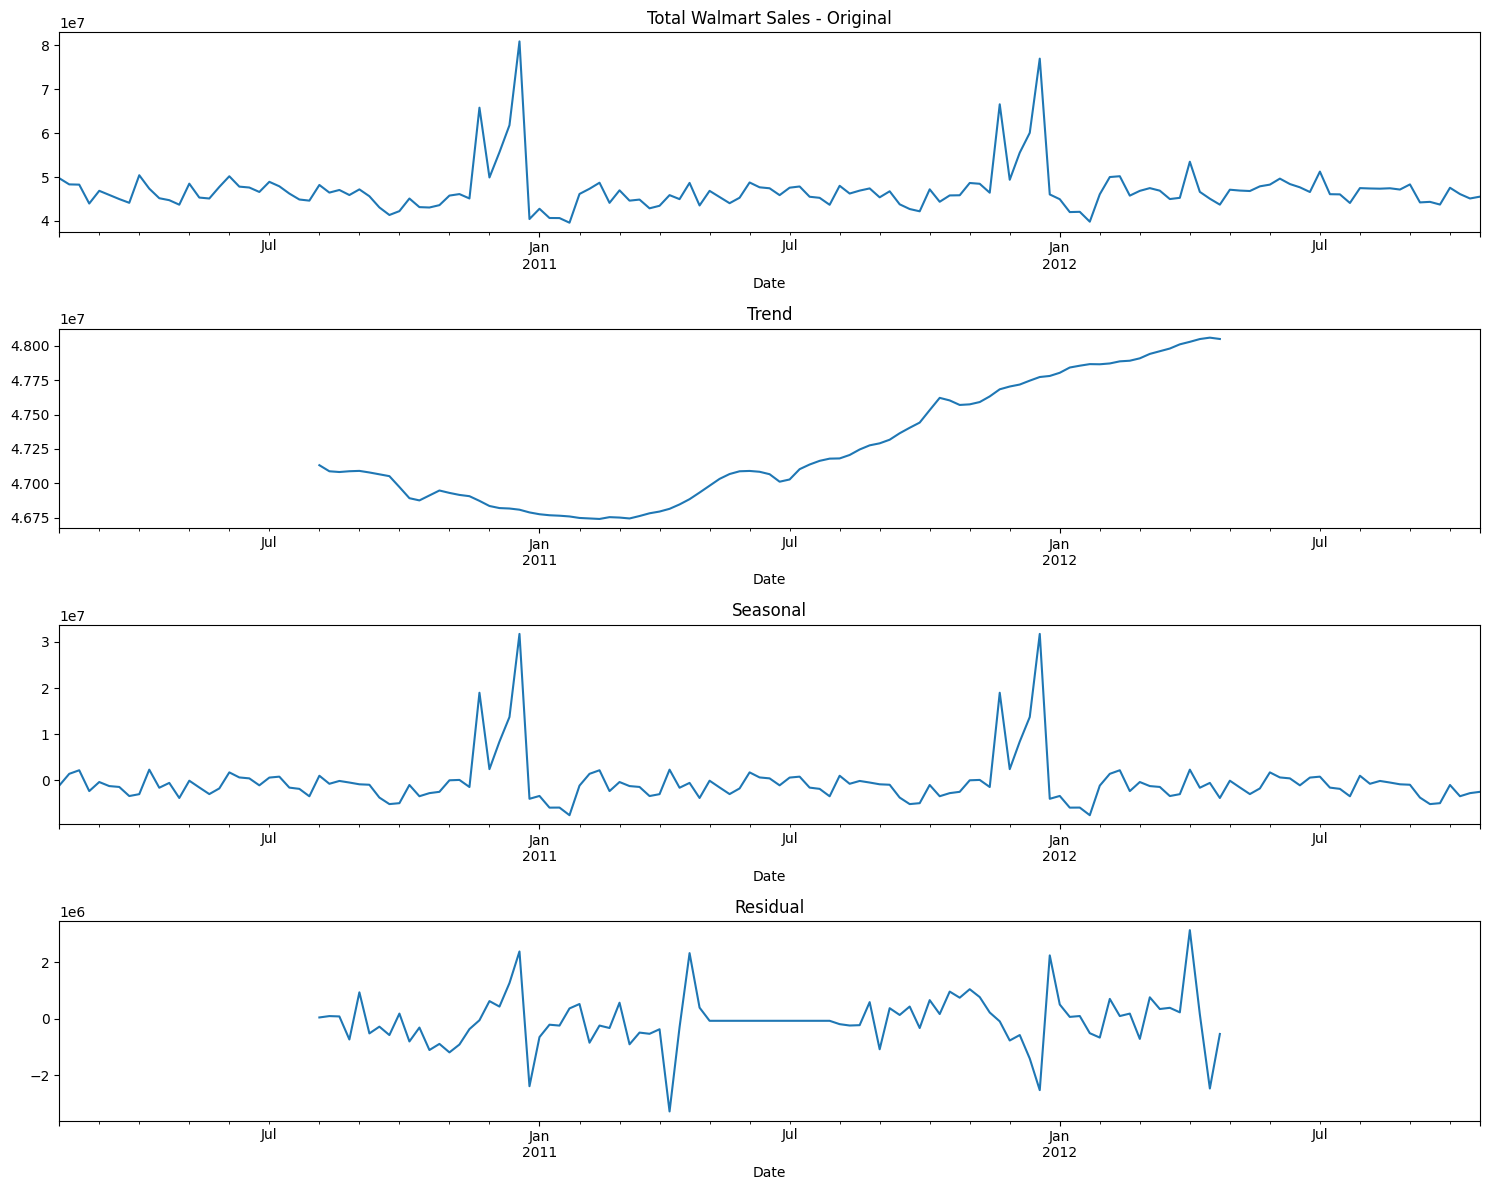

In [ ]:
ts_analyzer = TimeSeriesAnalyzer()
ts_preprocessor = WalmartTimeSeriesPreprocessor()

total_sales = ts_preprocessor.create_hierarchical_series(train_processed_clean, level='total')
print(f"Total sales series length: {len(total_sales)}")

store_sales = ts_preprocessor.create_hierarchical_series(train_processed_clean, level='store')
print(f"Store level data shape: {store_sales.shape}")

dept_sales = ts_preprocessor.create_hierarchical_series(train_processed_clean, level='dept')
print(f"Department level data shape: {dept_sales.shape}")

ts_analyzer.check_stationarity(total_sales, "Total Sales")

ts_analyzer.plot_decomposition(total_sales, freq=52, title="Total Walmart Sales")


## Split Data and Evaluation

In [ ]:
def create_time_series_splits(data, validation_size=0.2):
    data = data.copy()
    data['Date'] = pd.to_datetime(data['Date'])
    unique_dates = sorted(data['Date'].unique())
    total_periods = len(unique_dates)

    split_point = int(total_periods * (1 - validation_size))
    train_end_date = unique_dates[split_point - 1]
    val_start_date = unique_dates[split_point]

    train_data = data[data['Date'] <= train_end_date]
    val_data = data[data['Date'] >= val_start_date]

    print(f"Training period: {train_data['Date'].min()} to {train_data['Date'].max()}")
    print(f"Validation period: {val_data['Date'].min()} to {val_data['Date'].max()}")
    print(f"Training samples: {len(train_data)}, Validation samples: {len(val_data)}")

    return train_data, val_data

In [ ]:
def evaluate_time_series_model(model, train_series, val_series, model_name):
    try:
        fitted_model = model.fit()

        val_steps = len(val_series)
        forecast = fitted_model.forecast(steps=val_steps)

        mae = mean_absolute_error(val_series, forecast)
        mse = mean_squared_error(val_series, forecast)
        rmse = np.sqrt(mse)

        mape = np.mean(np.abs((val_series - forecast) / val_series)) * 100

        metrics = {
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'AIC': fitted_model.aic,
            'BIC': fitted_model.bic
        }

        print(f"\n{model_name} Validation Results:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

        return fitted_model, forecast, metrics

    except Exception as e:
        print(f"Error evaluating {model_name}: {e}")
        return None, None, None

In [ ]:
train_split, val_split = create_time_series_splits(train_processed_clean, validation_size=0.2)

train_total_sales = ts_preprocessor.create_hierarchical_series(train_split, level='total')
val_total_sales = ts_preprocessor.create_hierarchical_series(val_split, level='total')

print(f"Training series length: {len(train_total_sales)}")
print(f"Validation series length: {len(val_total_sales)}")

Training period: 2010-02-05 00:00:00 to 2012-04-06 00:00:00
Validation period: 2012-04-13 00:00:00 to 2012-10-26 00:00:00
Training samples: 335761, Validation samples: 85809
Training series length: 114
Validation series length: 29


# ARIMA

In [ ]:
class ARIMAModeler:
    def __init__(self):
        self.models = {}
        self.best_params = {}
        self.predictions = {}

    def auto_arima_search(self, series, seasonal=False, m=52):
        try:
            if seasonal:
                auto_model = pm.auto_arima(
                    series,
                    start_p=0, start_q=0,
                    max_p=3, max_q=3,
                    seasonal=True,
                    start_P=0, start_Q=0,
                    max_P=2, max_Q=2,
                    m=m,
                    stepwise=True,
                    suppress_warnings=True,
                    error_action='ignore'
                )
            else:
                auto_model = pm.auto_arima(
                    series,
                    start_p=0, start_q=0,
                    max_p=5, max_q=5,
                    seasonal=False,
                    stepwise=True,
                    suppress_warnings=True,
                    error_action='ignore'
                )

            return auto_model.order, auto_model.seasonal_order if seasonal else None

        except Exception as e:
            print(f"Auto ARIMA search failed: {e}")
            return (1, 1, 1), (1, 1, 1, 52) if seasonal else None

    def fit_arima(self, series, order=None, name="ARIMA"):
        if order is None:
            order, _ = self.auto_arima_search(series, seasonal=False)
        try:
            model = ARIMA(series, order=order)
            fitted_model = model.fit()

            self.models[name] = fitted_model
            self.best_params[name] = {'order': order}

            print(f"ARIMA{order} model fitted successfully")
            print(f"AIC: {fitted_model.aic:.2f}")
            print(f"BIC: {fitted_model.bic:.2f}")

            return fitted_model

        except Exception as e:
            print(f"ARIMA model fitting failed: {e}")
            return None

    def predict(self, model_name, steps):
        if model_name not in self.models:
            raise ValueError(f"Model {model_name} not found")
        model = self.models[model_name]
        forecast = model.forecast(steps=steps)

        self.predictions[model_name] = forecast
        return forecast

    def evaluate(self, model_name, actual_values):
        if model_name not in self.predictions:
            raise ValueError(f"No predictions found for {model_name}")

        predictions = self.predictions[model_name]
        min_len = min(len(predictions), len(actual_values))
        pred_aligned = predictions[:min_len]
        actual_aligned = actual_values[:min_len]

        mae = mean_absolute_error(actual_aligned, pred_aligned)
        mse = mean_squared_error(actual_aligned, pred_aligned)
        rmse = np.sqrt(mse)

        return {'MAE': mae, 'MSE': mse, 'RMSE': rmse}

## Training

In [ ]:
with mlflow.start_run(run_name="ARIMA_Training"):
    arima_modeler = ARIMAModeler()

    mlflow.log_param("model_type", "ARIMA")
    mlflow.log_param("validation_size", 0.2)
    mlflow.log_param("total_stores", train_processed_clean['Store'].nunique())
    mlflow.log_param("total_departments", train_processed_clean['Dept'].nunique())

    print("\n1. Training ARIMA on Total Sales with Validation")
    order, _ = arima_modeler.auto_arima_search(train_total_sales, seasonal=False)
    print(f"Optimal ARIMA order: {order}")
    arima_model = ARIMA(train_total_sales, order=order)
    fitted_model, forecast, metrics = evaluate_time_series_model(
        arima_model, train_total_sales, val_total_sales, "ARIMA_Total"
    )

    if fitted_model:
        mlflow.log_param("arima_order", str(order))
        for metric_name, metric_value in metrics.items():
            mlflow.log_metric(f"total_{metric_name.lower()}", metric_value)

        final_model = ARIMA(pd.concat([train_total_sales, val_total_sales]), order=order).fit()
        arima_modeler.models["ARIMA_Total"] = final_model
        joblib.dump(final_model, 'models/arima_total_model.pkl')
        mlflow.log_artifact('models/arima_total_model.pkl')

    print("\n2. Training ARIMA for Top 5 Stores with Validation")
    top_stores = train_split.groupby('Store')['Weekly_Sales'].sum().nlargest(5).index

    store_arima_models = {}
    store_metrics = {}

    for store in top_stores:
        print(f"\nTraining ARIMA for Store {store}")
        store_train_data = train_split[train_split['Store'] == store]
        store_val_data = val_split[val_split['Store'] == store]

        if len(store_train_data) > 20 and len(store_val_data) > 5:
            store_train_series = store_train_data.groupby('Date')['Weekly_Sales'].sum().sort_index()
            store_val_series = store_val_data.groupby('Date')['Weekly_Sales'].sum().sort_index()
            order, _ = arima_modeler.auto_arima_search(store_train_series, seasonal=False)
            store_model = ARIMA(store_train_series, order=order)
            fitted_store_model, store_forecast, store_metrics_dict = evaluate_time_series_model(
                store_model, store_train_series, store_val_series, f"ARIMA_Store_{store}"
            )

            if fitted_store_model:
                store_metrics[store] = store_metrics_dict
                for metric_name, metric_value in store_metrics_dict.items():
                    mlflow.log_metric(f"store_{store}_{metric_name.lower()}", metric_value)
                combined_store_data = pd.concat([
                    train_split[train_split['Store'] == store],
                    val_split[val_split['Store'] == store]
                ])
                combined_store_series = combined_store_data.groupby('Date')['Weekly_Sales'].sum().sort_index()
                final_store_model = ARIMA(combined_store_series, order=order).fit()
                store_arima_models[store] = final_store_model
        else:
            print(f"Insufficient data for store {store}")

    joblib.dump(store_arima_models, 'models/arima_store_models.pkl')
    mlflow.log_artifact('models/arima_store_models.pkl')

    print("\nARIMA Training with Validation Complete!")


1. Training ARIMA on Total Sales with Validation
Optimal ARIMA order: (5, 0, 0)

ARIMA_Total Validation Results:
MAE: 1673770.7698
MSE: 4510959513276.3662
RMSE: 2123901.9547
MAPE: 3.6212
AIC: 3859.6150
BIC: 3878.7684

2. Training ARIMA for Top 5 Stores with Validation

Training ARIMA for Store 20

ARIMA_Store_20 Validation Results:
MAE: 97975.2132
MSE: 15748374125.9291
RMSE: 125492.5262
MAPE: 4.7994
AIC: 3188.4517
BIC: 3196.6603

Training ARIMA for Store 14

ARIMA_Store_14 Validation Results:
MAE: 352375.2587
MSE: 154938506880.4895
RMSE: 393622.2896
MAPE: 21.4183
AIC: 3196.6804
BIC: 3207.6252

Training ARIMA for Store 4

ARIMA_Store_4 Validation Results:
MAE: 112649.7077
MSE: 16445045715.5733
RMSE: 128238.2381
MAPE: 5.3177
AIC: 3159.6295
BIC: 3167.8116

Training ARIMA for Store 13

ARIMA_Store_13 Validation Results:
MAE: 74106.3973
MSE: 8039728441.8988
RMSE: 89664.5328
MAPE: 3.5704
AIC: 3180.4677
BIC: 3188.6763

Training ARIMA for Store 2

ARIMA_Store_2 Validation Results:
MAE: 74605.

## Pipline

In [6]:
class ARIMAPredictionPipeline:
    def __init__(self, preprocessing_pipeline_path='preprocessing_pipeline.pkl',
                 model_path='models/arima_total_model.pkl',
                 store_models_path='models/arima_store_models.pkl'):
        self.preprocessing_pipeline = joblib.load(preprocessing_pipeline_path)
        self.arima_model = joblib.load(model_path)
        self.store_models = joblib.load(store_models_path)
        self.historical_data = None

    def prepare_historical_data(self, train_data):
        train_processed = self.preprocessing_pipeline.transform(train_data)
        train_processed = drop_lag_features(train_processed, lag_columns_to_drop)
        self.historical_proportions = train_processed.groupby(['Store', 'Dept'])['Weekly_Sales'].sum()
        self.total_historical = train_processed['Weekly_Sales'].sum()
        self.proportions_dict = (self.historical_proportions / self.total_historical).to_dict()
        self.last_train_date = pd.to_datetime(train_processed['Date']).max()
        self.avg_sales_by_store_dept = train_processed.groupby(['Store', 'Dept'])['Weekly_Sales'].mean().to_dict()
        print(f"Historical data prepared. Last training date: {self.last_train_date}")

    def process_test_data(self, test_data):
        print("Processing test data...")
        test_processed = self.preprocessing_pipeline.transform(test_data)
        test_processed = drop_lag_features(test_processed, lag_columns_to_drop)
        test_processed['Date'] = pd.to_datetime(test_processed['Date'])
        return test_processed

    def generate_forecasts(self, test_processed):
        print("Generating forecasts...")
        test_dates = sorted(test_processed['Date'].unique())
        n_periods = len(test_dates)
        print(f"Forecasting {n_periods} periods ahead...")
        total_forecast = self.arima_model.forecast(steps=n_periods)
        forecast_by_date = dict(zip(test_dates, total_forecast))
        predictions = []
        for idx, row in test_processed.iterrows():
            store = row['Store']
            dept = row['Dept']
            date = row['Date']
            base_forecast = forecast_by_date.get(date, 0)
            proportion = self.proportions_dict.get((store, dept), 0)
            if store in self.store_models:
                try:
                    days_diff = (date - self.last_train_date).days
                    periods_ahead = max(1, days_diff // 7)
                    store_forecast = self.store_models[store].forecast(steps=periods_ahead)
                    store_value = store_forecast.iloc[-1] if hasattr(store_forecast, 'iloc') else store_forecast[-1]
                    store_data = self.historical_proportions[self.historical_proportions.index.get_level_values('Store') == store]
                    if len(store_data) > 0:
                        store_total = store_data.sum()
                        dept_in_store = self.historical_proportions.get((store, dept), 0)
                        dept_proportion = dept_in_store / store_total if store_total > 0 else 0
                        prediction = store_value * dept_proportion
                    else:
                        prediction = base_forecast * proportion
                except:
                    prediction = base_forecast * proportion
            else:
                prediction = base_forecast * proportion
            prediction = max(0, prediction)
            predictions.append({
                'Store': store,
                'Dept': dept,
                'Date': date,
                'Weekly_Sales': prediction
            })
            if idx % 10000 == 0:
                print(f"Processed {idx}/{len(test_processed)} predictions...")
        return pd.DataFrame(predictions)

    def create_submission(self, predictions_df):
        print("Creating submission file...")
        submission = pd.DataFrame()
        submission['Id'] = (predictions_df['Store'].astype(str) + '_' +
                           predictions_df['Dept'].astype(str) + '_' +
                           predictions_df['Date'].dt.strftime('%Y-%m-%d'))
        submission['Weekly_Sales'] = predictions_df['Weekly_Sales'].round(2)
        return submission

    def run_pipeline(self, train_data, test_data, output_file='submission_arima.csv'):
        print("\nStep 1: Preparing historical data...")
        self.prepare_historical_data(train_data)
        print("\nStep 2: Processing test data...")
        test_processed = self.process_test_data(test_data)
        print("\nStep 3: Generating forecasts...")
        predictions_df = self.generate_forecasts(test_processed)
        print("\nStep 4: Creating submission file...")
        submission = self.create_submission(predictions_df)
        submission.to_csv(output_file, index=False)
        print(f"\nSubmission saved to: {output_file}")
        print("\nSubmission Statistics:")
        print(f"Total predictions: {len(submission)}")
        print(f"Mean prediction: ${submission['Weekly_Sales'].mean():,.2f}")
        print(f"Std prediction: ${submission['Weekly_Sales'].std():,.2f}")
        print(f"Min prediction: ${submission['Weekly_Sales'].min():,.2f}")
        print(f"Max prediction: ${submission['Weekly_Sales'].max():,.2f}")
        print(f"Zero predictions: {(submission['Weekly_Sales'] == 0).sum()}")
        print("\nFirst 10 predictions:")
        print(submission.head(10))
        return submission

In [13]:
pipeline = ARIMAPredictionPipeline()
train_raw = pd.read_csv('data/train.csv')
test_raw = pd.read_csv('data/test.csv')
submission = pipeline.run_pipeline(train_raw, test_raw, 'submission_arima.csv')


Step 1: Preparing historical data...
Dropped 12 lag/MA columns: ['Sales_Lag_1', 'Sales_Lag_2', 'Sales_Lag_3', 'Sales_Lag_4', 'Sales_Lag_8', 'Sales_Lag_52', 'Sales_MA_4', 'Sales_MA_8', 'Sales_MA_12', 'Sales_STD_4', 'Sales_STD_8', 'Sales_STD_12']
Historical data prepared. Last training date: 2012-10-26 00:00:00

Step 2: Processing test data...
Processing test data...
Dropped 12 lag/MA columns: ['Sales_Lag_1', 'Sales_Lag_2', 'Sales_Lag_3', 'Sales_Lag_4', 'Sales_Lag_8', 'Sales_Lag_52', 'Sales_MA_4', 'Sales_MA_8', 'Sales_MA_12', 'Sales_STD_4', 'Sales_STD_8', 'Sales_STD_12']

Step 3: Generating forecasts...
Generating forecasts...
Forecasting 39 periods ahead...
Processed 0/115064 predictions...
Processed 10000/115064 predictions...
Processed 20000/115064 predictions...
Processed 30000/115064 predictions...
Processed 40000/115064 predictions...
Processed 50000/115064 predictions...
Processed 60000/115064 predictions...
Processed 70000/115064 predictions...
Processed 80000/115064 predictions

In [17]:
mlflow.set_experiment("ARIMA_Training")
with mlflow.start_run(run_name="ARIMA_Pipeline"):
    mlflow.log_param("pipeline_type", "hierarchical_forecast")
    mlflow.log_param("total_predictions", len(submission))
    mlflow.log_metric("mean_prediction", submission['Weekly_Sales'].mean())
    mlflow.log_metric("std_prediction", submission['Weekly_Sales'].std())
    mlflow.log_metric("min_prediction", submission['Weekly_Sales'].min())
    mlflow.log_metric("max_prediction", submission['Weekly_Sales'].max())
    mlflow.log_artifact('submission_arima.csv')
    joblib.dump(pipeline, 'arima_prediction_pipeline.pkl')
    mlflow.log_artifact('arima_prediction_pipeline.pkl')


🏃 View run ARIMA_Pipeline at: https://dagshub.com/egval20/ML-Final.mlflow/#/experiments/4/runs/512f5b99108f42c29141ec81656800ef
🧪 View experiment at: https://dagshub.com/egval20/ML-Final.mlflow/#/experiments/4
